# **Text Classifier with the IMDB Reviews Dataset**


This notebook showcases the implementation of text classification model using LSTM networks for sentiment analysis. Its purpose is to distinguish between positive and negative movie reviews in the [IMDB Reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/). Additionally, it includes visualization of word embeddings generated post-training.

### **Imports**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import textwrap
from IPython.core.display import HTML
from google.colab import drive
import imageio.v2 as imageio
import os

### **Parameters**

In [ ]:
epochs = 5
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
vocab_size = 50000 #Including padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("imdb_reviews",
                                                split=["train + test[:60%]", "test[60%:]"],
                                                as_supervised=True,
                                                with_info=True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6FOZPX/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6FOZPX/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6FOZPX/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpj8419wh5tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

In [ ]:
len(train_dataset), len(test_dataset)

(40000, 10000)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
for text, label in train_dataset.take(1):
  print(text[:3].numpy(), "\n")
  print(label[:3].numpy())

[b'Will Smith is smooth as usual in the movie Hitch. Smiths character Hitch is a date doctor. He dates Mendes character who is a gossip columnist. At one point Hitch shows his love interest her Great Grandfathers name in the immigration book at Ellis Island pretending what is actually an arranged event is a coincidence. Not long after I mentioned starlight in my previous review today. There was a view of the starry sky in survivor hinting that My Moon 168 Rtexas already knew that was going to be there due to faster than light communications.<br /><br />The male star from the show The King of Queens is very funny in this movie especially his dance moves. The allergic reaction on Hitchs face is a little cruel to laugh at even though it is just pretend.<br /><br />My latest message from my Daughter Julias Artificial Intelligence computer on the Creator of Humans Home world Coaltrain that my Moon 168 as part of Moonfleet is near says: "Daddy I\'m Okay again." Her messages are always very s

**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize="lower_and_strip_punctuation" #Default
                                            )
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [ ]:
print(encoder.vocabulary_size())
vocab[:10]

50000


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U72')

In [ ]:
encoded_text = encoder(text)[:3].numpy()
print(encoded_text.shape)
encoded_text

(3, 926)


array([[   80,  1400,     7, ...,     0,     0,     0],
       [10550,  1178,    39, ...,     0,     0,     0],
       [    2,    20,     7, ...,     0,     0,     0]])

In [ ]:
# Visualizing text processing
print(textwrap.fill(text[0].numpy().decode("utf-8"), width=100), "\n")
print(textwrap.fill(" ".join(vocab[encoded_text[0]]), width=100))

Will Smith is smooth as usual in the movie Hitch. Smiths character Hitch is a date doctor. He dates
Mendes character who is a gossip columnist. At one point Hitch shows his love interest her Great
Grandfathers name in the immigration book at Ellis Island pretending what is actually an arranged
event is a coincidence. Not long after I mentioned starlight in my previous review today. There was
a view of the starry sky in survivor hinting that My Moon 168 Rtexas already knew that was going to
be there due to faster than light communications.<br /><br />The male star from the show The King of
Queens is very funny in this movie especially his dance moves. The allergic reaction on Hitchs face
is a little cruel to laugh at even though it is just pretend.<br /><br />My latest message from my
Daughter Julias Artificial Intelligence computer on the Creator of Humans Home world Coaltrain that
my Moon 168 as part of Moonfleet is near says: "Daddy I'm Okay again." Her messages are always very
short

### **Build the Model**

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(),
                              output_dim=embedding_dim,
                              mask_zero=True, #To handle variable sequence lengths
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

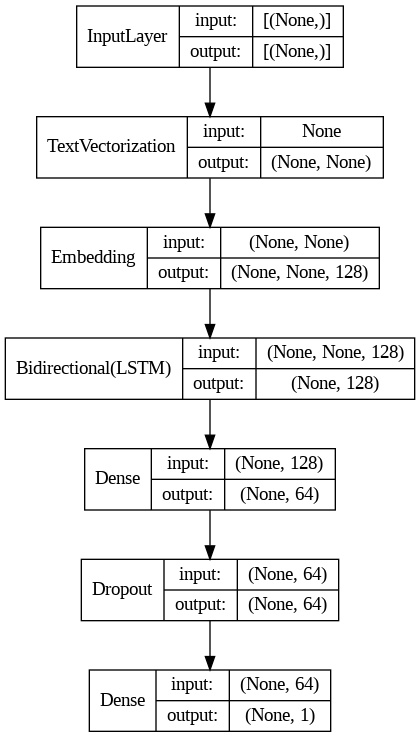

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics="accuracy")

In [ ]:
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/5
313/313 [==============================] - 65s 172ms/step - loss: 0.6203 - accuracy: 0.6496 - val_loss: 0.4023 - val_accuracy: 0.8321
Epoch 2/5
313/313 [==============================] - 45s 144ms/step - loss: 0.3305 - accuracy: 0.8720 - val_loss: 0.3031 - val_accuracy: 0.8769
Epoch 3/5
313/313 [==============================] - 41s 130ms/step - loss: 0.2265 - accuracy: 0.9198 - val_loss: 0.2716 - val_accuracy: 0.8976
Epoch 4/5
313/313 [==============================] - 39s 125ms/step - loss: 0.1803 - accuracy: 0.9384 - val_loss: 0.2558 - val_accuracy: 0.8984
Epoch 5/5
313/313 [==============================] - 34s 108ms/step - loss: 0.1324 - accuracy: 0.9578 - val_loss: 0.2583 - val_accuracy: 0.9024


**Save model**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
model.save("/content/drive/MyDrive/models/TextClassificationLSTM_IMDB.keras")

### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.08984845876693726, 0.9757000207901001]
[0.25833582878112793, 0.902400016784668]


The training set achieves an accuracy of 98% in just 5 epochs, while the testing set accuracy is 90%. This suggests the model is good but exhibits overfitting issues, despite expanding the training set and utilizing a dropout layer. Even if we add a few more epochs, the training set accuracy might reach 100%, but the testing set accuracy would start to decrease. To achieve better results, it would be advisable to further expand the training set or even use more robust architectures like transformer networks.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=epochs):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()

In [ ]:
plot_metrics(metric="accuracy")

**Images for GitHub**

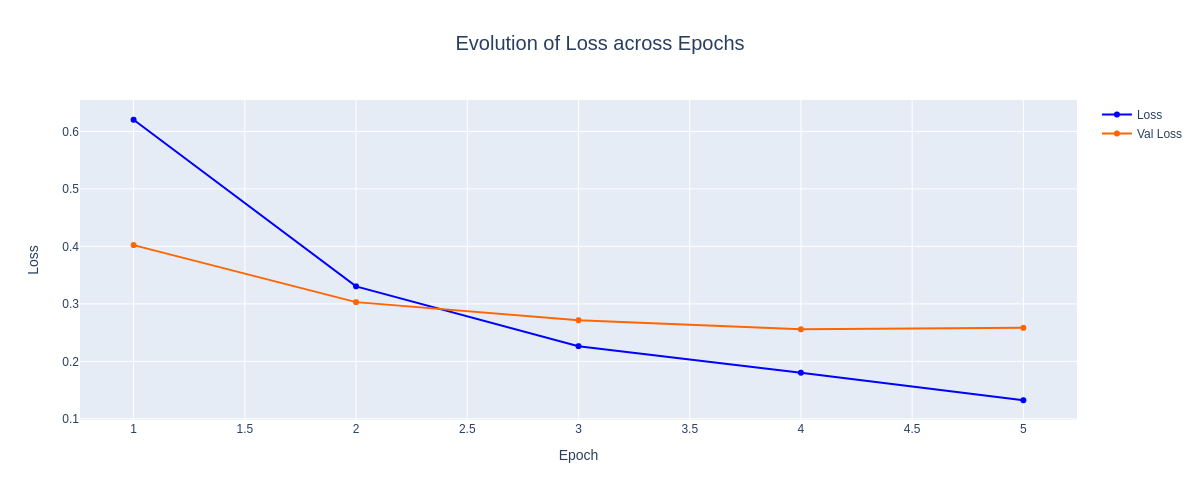

In [ ]:
plot_metrics(renderer="png")

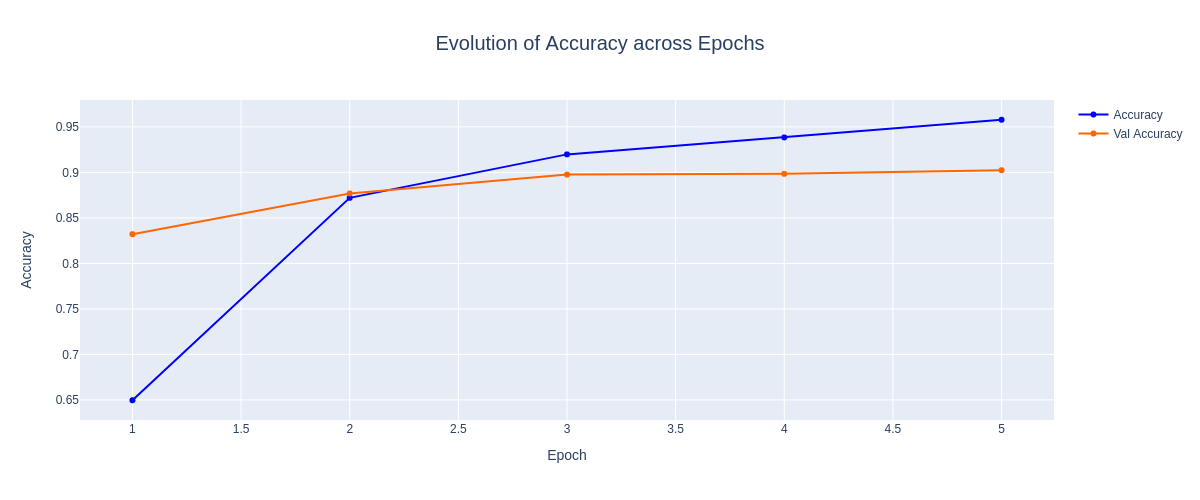

In [ ]:
plot_metrics(renderer="png", metric="accuracy")

**Confusion Matrix**

In [ ]:
labels_test = test_dataset.unbatch().map(lambda text, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [ ]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9024

Total negatives:  4970 ; Total positives:  5030


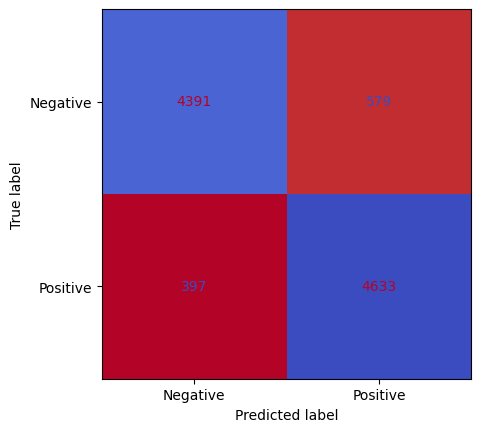

In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total negatives: ", np.bincount(labels_test)[0], "; Total positives: ", np.bincount(labels_test)[1])

In [ ]:
(579/4970)*100, (397/5030)*100

(11.64989939637827, 7.892644135188867)

It is observed that the model encounters slightly more difficulties in correctly classifying negative reviews, as reflected in a higher percentage of false positives (11.6%) compared to false negatives (7.9%). This discrepancy may be due to the presence of positive words in some negative reviews within the embedding space. Despite employing a bidirectional LSTM network, the model may not have sufficient capacity to capture the complex relationships present in long reviews, as a Transformer network would.

### **Predictions with the trained model**

In [3]:
# Load model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/TextClassificationLSTM_IMDB.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
def predict_review(texts, labels, random=True):
  label_names = ["Negative Review", "Positive Review"]
  label_colors = ["red", "green"]
  indice = np.random.choice(len(texts)) if random else 0
  labels_pred = model.predict(texts, verbose=0).squeeze(axis=-1)
  labels_pred = (labels_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>Review:</b><br><br>
    {texts[indice].numpy().decode("utf-8")}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[labels_pred[indice]]}">{label_names[labels_pred[indice]]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [ ]:
texts, labels = next(iter(test_dataset))

In [ ]:
predict_review(texts, labels, random=False)

In [ ]:
predict_review(texts, labels)

In [ ]:
# Long Review
predict_review(texts, labels)

In [ ]:
# Long Review
predict_review(texts, labels)

**Other Reviews**

In [ ]:
text = """
'The Sunrise of Tomorrow' is a cinematic masterpiece that truly captures the essence of human resilience.
The performances are stellar, particularly the lead actor who delivers a heart-wrenching performance that leaves you on the edge of your seat.
The cinematography is breathtaking, with each frame painting a beautiful picture that stays with you long after the movie ends.
The plot is well-crafted, with unexpected twists that keep you engaged throughout.
This movie is a must-watch for anyone seeking a profound cinematic experience.
"""
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_review(text, label)

In [ ]:
text = """
I had high hopes for "The Sunrise of Tomorrow", but unfortunately, it fell short of expectations.
The plot was predictable and lacked depth, making it difficult to connect with the characters on any meaningful level.
The performances felt forced and lacked the emotional depth necessary for such a storyline.
The cinematography, while visually appealing, couldn't make up for the lackluster script.
Overall, the movie felt like a missed opportunity to explore an interesting concept.
"""
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_review(text, label)

In [ ]:
# Complex positive review, incorporating seemingly negative words.

text = """
I'm absolutely disgusted that this movie isn't being sold. Everyone who loves this film should email Disney to increase the demand for it.
Eventually, they'd have to sell it, and then I'd buy copies for everybody I know. Everyone and everything in this movie did a good job,
and I can't figure out why Disney hasn't put it on DVD or even on VHS in rental stores.
I haven't seen any copies. This is a fantastic movie that deserves to be seen by all the kids in the new generation.
They're missing out, and I think they deserve the chance to experience it.
"""
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_review(text, label)

It is evident that the model has classified the review correctly, suggesting that it is capable of adequately capturing semantic relationships in short reviews, even when they are complex, thanks to the use of LSTM networks.

### **Visualize Word Embeddings with Principal Component Analysis (PCA)**

In [4]:
# Obtaining the vocabulary from the encoder layer and the weights from the trained embedding layer

vocab = model.layers[0].get_vocabulary()
vocab = {word:i for i, word in enumerate(vocab)}

embedding = model.get_layer("embedding").get_weights()[0]
embedding.shape #(vocab_size, embedding_dim)

(50000, 128)

In [5]:
def compute_pca(X, n_components=2):
  pca = PCA(n_components=n_components, random_state=42)
  X_pca = pca.fit_transform(X)
  return X_pca

In [6]:
embedding_2d = compute_pca(embedding)
embedding_3d = compute_pca(embedding, n_components=3)

embedding_2d.shape, embedding_3d.shape

((50000, 2), (50000, 3))

In [7]:
# Some exemplary words
words = ["good", "excellent", "great", "fantastic", "amazing", "wonderful", "outstanding", "superb", "delightful", "phenomenal",
         "bad", "terrible", "awful", "horrible", "mediocre", "dreadful", "poor", "lousy", "disappointing", "abysmal"]

colors = ["green"]*10 + ["red"]*10

In [8]:
words_2d = np.array([embedding_2d[vocab.get(word, 1)] for word in words]) #Index 1 corresponds to [UNK]
words_3d = np.array([embedding_3d[vocab.get(word, 1)] for word in words])

**With Plotly (interactive graph)**

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=words_2d[:10, 0], y=words_2d[:10, 1],
                         mode="markers+text", marker_color="green",
                         text=words[:10], textposition="top center",
                         marker_size=10, textfont_size=13,
                         showlegend=False))

fig.add_trace(go.Scatter(x=words_2d[10:, 0], y=words_2d[10:, 1],
                         mode="markers+text", marker_color="red",
                         text=words[10:], textposition="top center",
                         marker_size=10, textfont_size=13,
                         showlegend=False))

fig.update_layout(title="<b>2D Word Embeddings Visualization</b>",
                  title_font=dict(size=20), title_x=0.5, height=600, width=1200,
                  xaxis_title="<b>$Z_1$</b>", yaxis_title="<b>$Z_2$</b>")

fig.show()

In [100]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=words_3d[:10, 0], y=words_3d[:10, 1], z=words_3d[:10, 2],
                           mode="markers+text", marker_color="green",
                           text=words[:10], textposition="top center",
                           marker_size=5, textfont_size=13,
                           showlegend=False))

fig.add_trace(go.Scatter3d(x=words_3d[10:, 0], y=words_3d[10:, 1], z=words_3d[10:, 2],
                           mode="markers+text", marker_color="red",
                           text=words[10:], textposition="top center",
                           marker_size=5, textfont_size=13,
                           showlegend=False))

fig.update_layout(title="<b>3D Word Embeddings Visualization</b>",
                  title_font=dict(size=16), title_x=0.5, height=600, width=900,
                  scene=dict(xaxis_title="<b>Z_1</b>", yaxis_title="<b>Z_2</b>", zaxis_title="<b>Z_3</b>"))

fig.show()

In [101]:
# Function to create gifs

def create_gif(gif_file, fig, fps=1):

  images = []
  angles = np.arange(0, 361, 20)
  fig.update_layout(title="")

  # Initial Image
  fig.write_image("temp.png")
  images.append(imageio.imread("temp.png"))
  os.remove("temp.png")

  for angle in angles:
    fig.update_layout(scene_camera=dict(
        eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)))
        )
    )
    fig.write_image("temp.png")
    images.append(imageio.imread("temp.png"))
    os.remove("temp.png")

  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    for image in images:
      writer.append_data(image)

In [11]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 2.6 MB/s eta 0:00:00



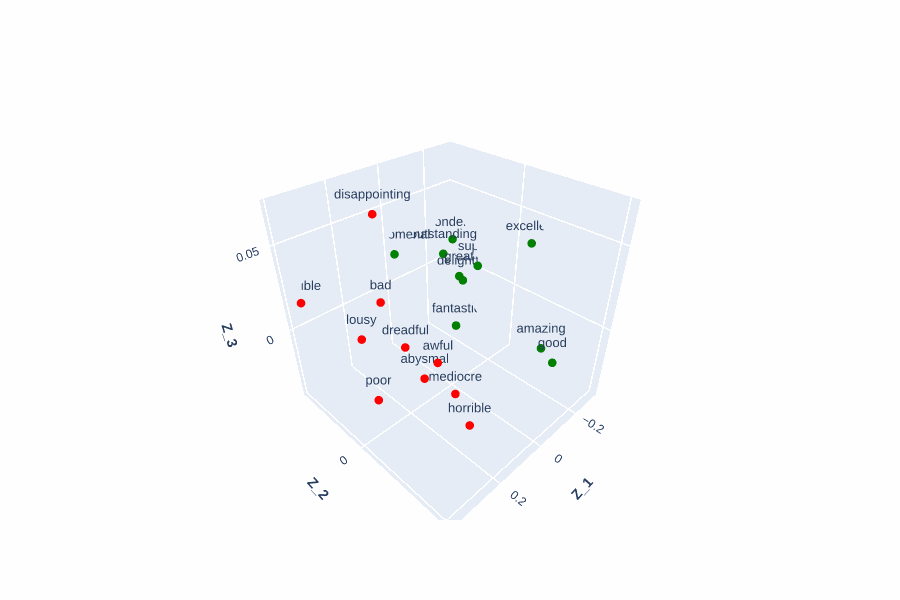

In [102]:
# Generate a GIF of the 3D word embeddings
directory_images = "/content/drive/MyDrive/images/text_classification"
directory_tc = os.path.join(directory_images, "lstm_imdb")
os.makedirs(directory_tc, exist_ok=True)
gif_file = os.path.join(directory_tc, "embedding_3d.gif")

create_gif(gif_file, fig, fps=0.5)
embed.embed_file(gif_file)

**With Matplotlib (for GitHub)**

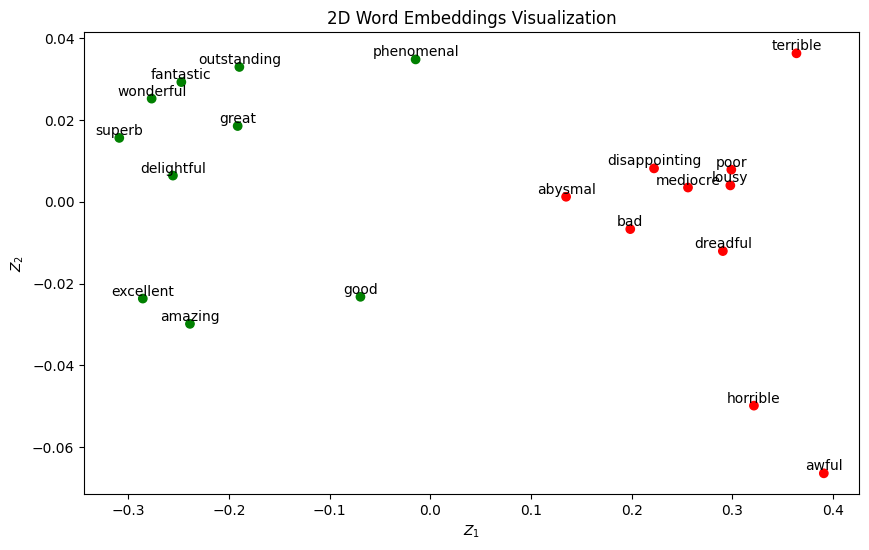

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(words_2d[:, 0], words_2d[:, 1], c=colors)
for i, word in enumerate(words):
    plt.annotate(word, xy=(words_2d[i, 0], words_2d[i, 1]), ha="center", va="bottom")

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.title("2D Word Embeddings Visualization")
plt.show()

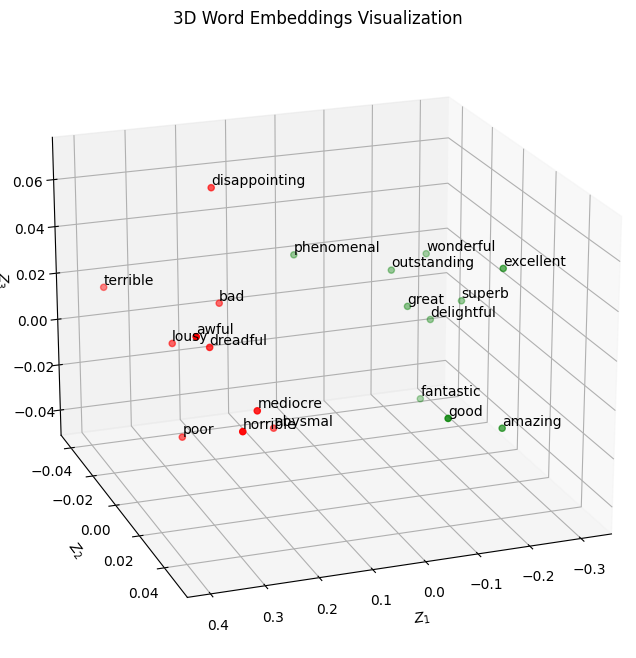

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(words_3d[:, 0], words_3d[:, 1], words_3d[:, 2], c=colors)

for i, word in enumerate(words):
    ax.text(words_3d[i, 0], words_3d[i, 1], words_3d[i, 2], word, ha="left", va="bottom")

ax.view_init(elev=20, azim=70)
ax.set_box_aspect(None, zoom=1.1)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_zlabel("$Z_3$")
plt.title("3D Word Embeddings Visualization")
plt.show()

Thanks to **PCA**, we can now visualize the trained weights of the embedding layer in both 2D and 3D, where each word in the vocabulary, previously of dimension 128, has been reduced and projected into a lower-dimensional space. This technique allows us to understand word distribution more clearly. Moreover, by observing the arrangement of words in the vector space, we can infer that the model has been trained successfully. Common words in positive reviews cluster coherently, as do words associated with negative reviews, suggesting a good capture of semantic relationships. Furthermore, a clear separation between these two groups of words is observed in the vector space, indicating good discrimination capability of the model.